# Probabilistic Bayesian Neural Network

```bash
pip install tensorflow-probability tensorflow-datasets
```

## Load wine data

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

def get_data(dataset_size=4898, batch_size=256):
    train_size = int(dataset_size * 0.85)
    dataset = tfds.load(name='wine_quality', as_supervised=True, split='train') \
        .map(lambda x, y: (x, tf.cast(y, tf.float32))) \
        .prefetch(buffer_size=dataset_size) \
        .cache()
    
    X_tr = dataset.take(train_size).shuffle(buffer_size=train_size).batch(batch_size)
    X_te = dataset.skip(train_size).batch(batch_size)

    return X_tr, X_te

X_tr, X_te = get_data()

2022-10-12 17:08:14.536741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-12 17:08:14.636828: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-12 17:08:15.079997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2022-10-12 17:08:15.080076: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: can

## Model

In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp

FEATURE_NAMES = list(X_tr.element_spec[0].keys())

def get_inputs():
    get_input = lambda feature: layers.Input(name=feature, shape=(1,), dtype=tf.float32)
    return  {feature_name: get_input(feature_name) for feature_name in FEATURE_NAMES}

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

def get_model(train_size, hidden_units=[8, 8]):
    inputs = get_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation='sigmoid',
        )(features)

    distribution_params = layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = get_model(100)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


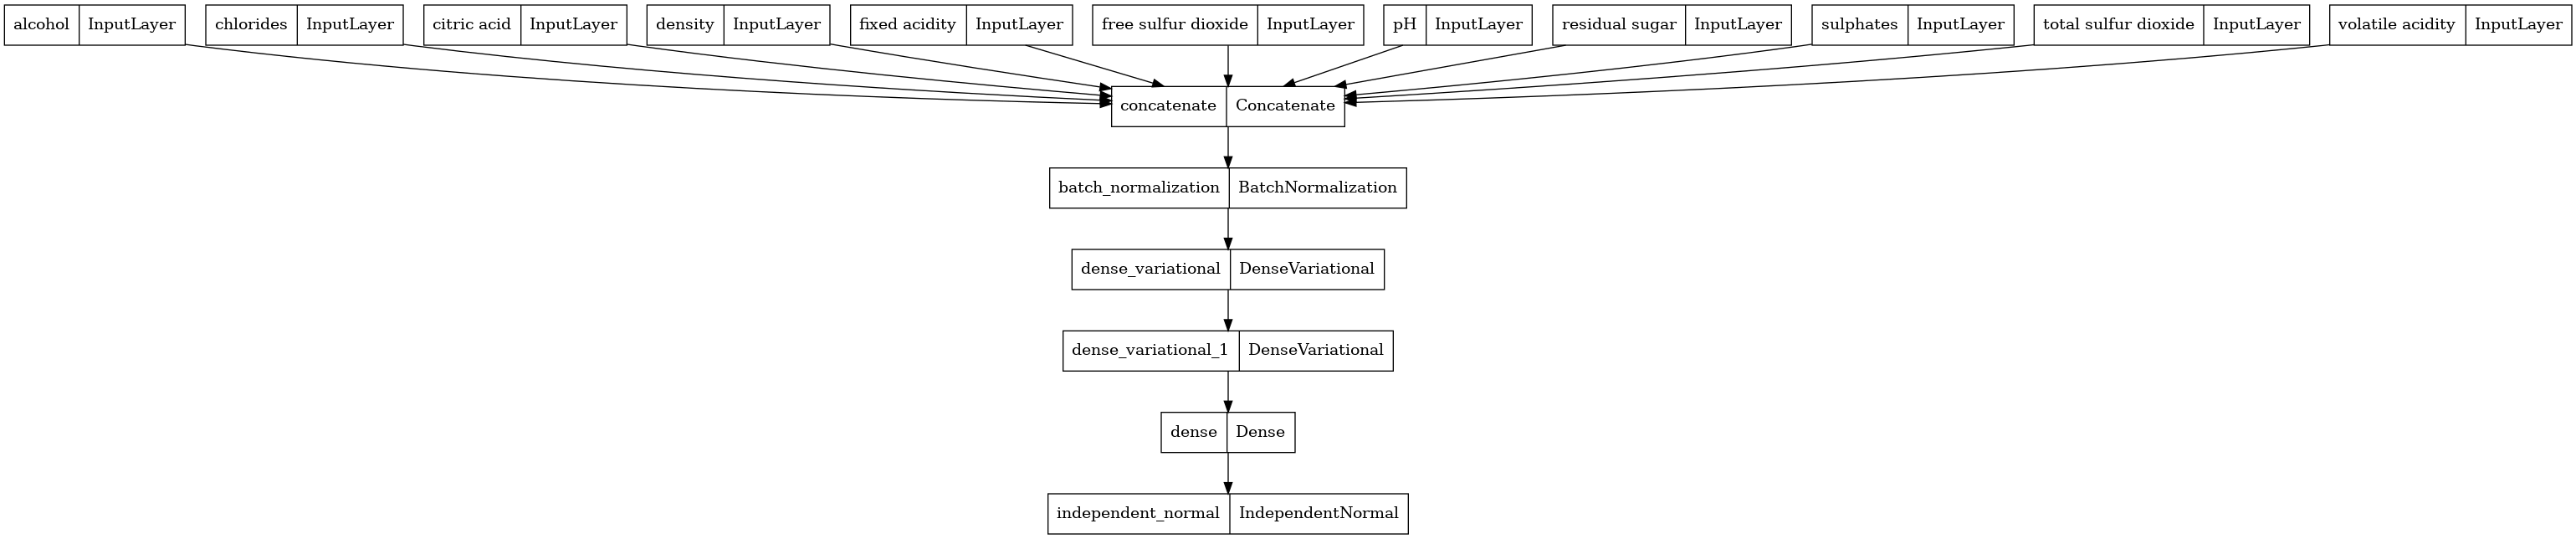

In [3]:
keras.utils.plot_model(model)

## Compile

In [4]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss=negative_loglikelihood,
    metrics=[keras.metrics.RootMeanSquaredError()],
)

## Fit

In [5]:
model.fit(x=X_tr, validation_data=X_te, epochs=1_000, verbose=0)

2022-10-12 17:08:37.935400: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-10-12 17:08:37.937019: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Evaluate

In [6]:
_, rmse_tr = model.evaluate(X_tr, verbose=0)
_, rmse_te = model.evaluate(X_te, verbose=0)

print(f'rmse_tr: {round(rmse_tr, 3)}, rmse_te: {round(rmse_te, 3)}')

rmse_tr: 1.23, rmse_te: 1.236


## Predict

In [7]:
sample = 10
examples, targets = list(X_te.unbatch().shuffle(256 * 10).batch(sample))[0]

dist_pred = model(examples)
mean_pred = dist_pred.mean().numpy().tolist()
stdv_pred = dist_pred.stddev().numpy()

upper = (mean_pred + (1.96 * stdv_pred)).tolist()
lower = (mean_pred - (1.96 * stdv_pred)).tolist()
stdv_pred = stdv_pred.tolist()

for idx in range(sample):
    print(
        f'Prediction mean: {round(mean_pred[idx][0], 2)}, '
        f'stddev: {round(stdv_pred[idx][0], 2)}, '
        f'95% CI: [{round(upper[idx][0], 2)} - {round(lower[idx][0], 2)}]'
        f' - Actual: {targets[idx]}'
    )

Prediction mean: 5.02, stddev: 0.85, 95% CI: [6.7 - 3.35] - Actual: 6.0
Prediction mean: 5.62, stddev: 0.86, 95% CI: [7.3 - 3.94] - Actual: 7.0
Prediction mean: 5.93, stddev: 0.86, 95% CI: [7.61 - 4.25] - Actual: 6.0
Prediction mean: 6.62, stddev: 0.86, 95% CI: [8.31 - 4.93] - Actual: 7.0
Prediction mean: 5.12, stddev: 0.85, 95% CI: [6.79 - 3.44] - Actual: 5.0
Prediction mean: 4.81, stddev: 0.85, 95% CI: [6.48 - 3.14] - Actual: 6.0
Prediction mean: 6.55, stddev: 0.86, 95% CI: [8.24 - 4.86] - Actual: 6.0
Prediction mean: 5.7, stddev: 0.86, 95% CI: [7.38 - 4.02] - Actual: 6.0
Prediction mean: 5.78, stddev: 0.86, 95% CI: [7.47 - 4.1] - Actual: 5.0
Prediction mean: 6.7, stddev: 0.86, 95% CI: [8.39 - 5.01] - Actual: 6.0
